# Introduction

Some few weeks ago I posted a tweet on “the most common neural net mistakes”, listing a few common gotchas related to training neural nets. The tweet got quite a bit more engagement than I anticipated (including a webinar :)). Clearly, a lot of people have personally encountered the large gap between “here is how a convolutional layer works” and “our convnet achieves state of the art results”.

# The data

In [3]:
from fastai.vision.all import *

In [4]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [5]:
(path/'images').ls()[0]

Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_115.jpg')

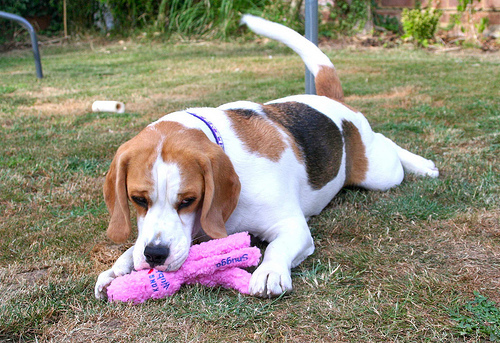

In [6]:
img_path = (path/'images').ls()[0]
PILImage.create(img_path)

In [7]:
img_paths = [path for path in (path/'images').ls() if path.suffix=='.jpg']
print(len(img_paths))

sizes = pd.Series(PILImage.create(img_path).shape for img_path in img_paths)
sizes.value_counts()

7390


(375, 500)     1425
(333, 500)     1072
(500, 375)      511
(500, 333)      509
(225, 300)      266
               ... 
(440, 459)        1
(450, 337)        1
(382, 600)        1
(849, 1200)       1
(286, 300)        1
Name: count, Length: 1022, dtype: int64

In [8]:
def get_label(img_path):
    img_name = img_path.name
    x = img_name.split('.')[0]
    return '_'.join(x.split('_')[:-1])

In [9]:
labels = pd.Series(get_label(img_path) for img_path in img_paths)
labels.value_counts()

beagle                        200
boxer                         200
Maine_Coon                    200
english_setter                200
american_pit_bull_terrier     200
Egyptian_Mau                  200
Persian                       200
keeshond                      200
chihuahua                     200
basset_hound                  200
english_cocker_spaniel        200
British_Shorthair             200
japanese_chin                 200
pug                           200
Bengal                        200
leonberger                    200
german_shorthaired            200
miniature_pinscher            200
Ragdoll                       200
pomeranian                    200
havanese                      200
Abyssinian                    200
wheaten_terrier               200
samoyed                       200
american_bulldog              200
Russian_Blue                  200
newfoundland                  200
yorkshire_terrier             200
Bombay                        200
Sphynx        

In [10]:
x_tfms = [PILImage.create, Resize(350), ToTensor()]
categories = Categorize(vocab=labels.unique())
y_tfms = [Transform(get_label), categories]
dsets = Datasets(img_paths, [x_tfms, y_tfms])

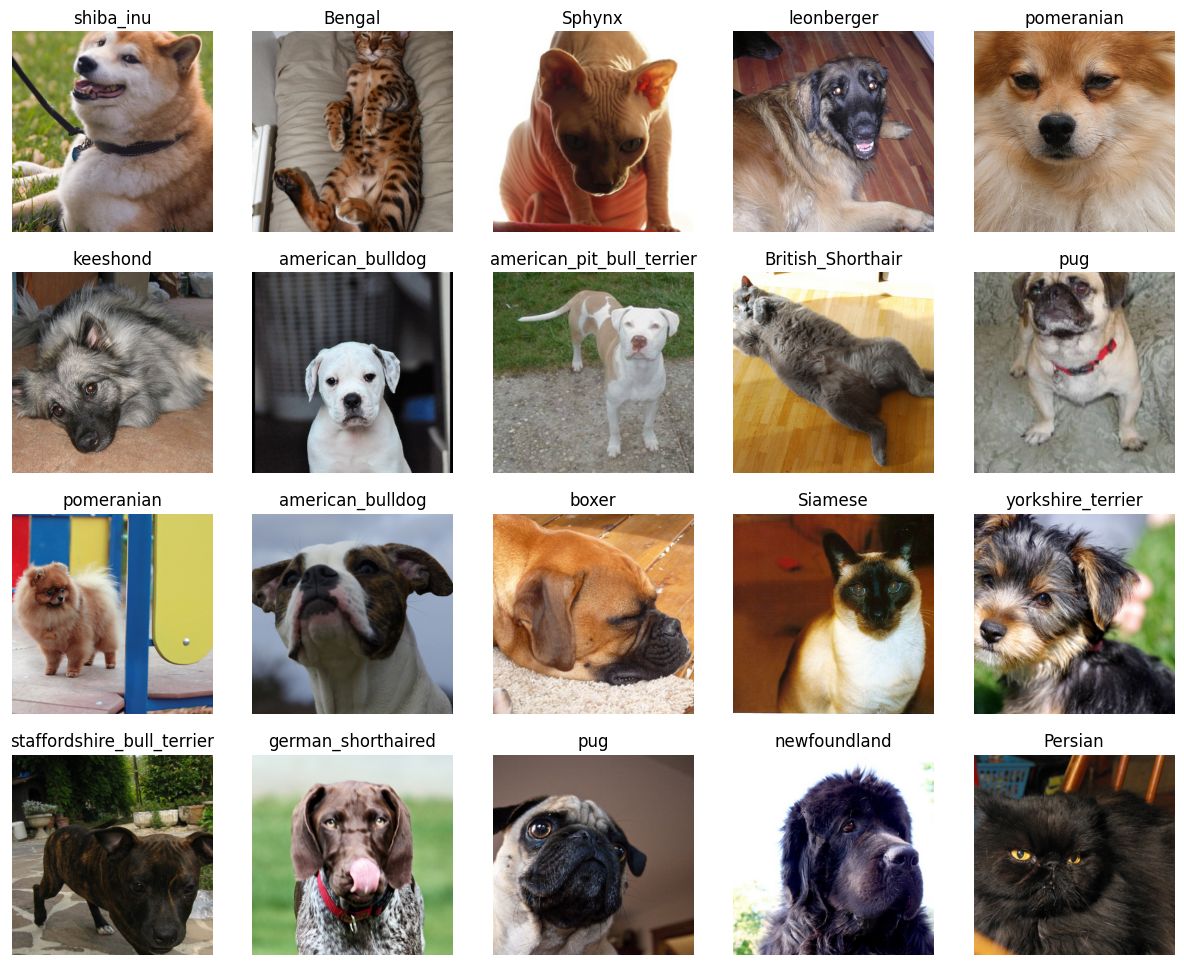

In [11]:
dls = dsets.dataloaders(bs=32)
dls.show_batch(max_n=20, ncols=5)

In [12]:
dsets = dsets = Datasets(img_paths, [x_tfms, y_tfms], splits=RandomSplitter()(img_paths))

def get_dls(bs, resize=224):
    batch_tfms = [IntToFloatTensor(), Resize(resize), Normalize.from_stats(*imagenet_stats)]
    return dsets.dataloaders(bs=bs, after_batch=batch_tfms)

# Baselines

## Dumb baseline

In [13]:
n_classes = len(categories.vocab)
1/n_classes

0.02702702702702703

## Input independent baseline

In [14]:
class ConvBlock(nn.Sequential):
    def __init__(self, ni, nf, stride=2):
        super().__init__(nn.Conv2d(ni, nf, 3, stride=stride), nn.ReLU())

In [15]:
class CNN(nn.Sequential):
    def __init__(self, n_classes, channels=[3,16,32,64,128,256]):
        cnn_layers = [ConvBlock(ni, nf) for ni, nf in zip(channels, channels[1:])]
        pooling = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten())
        super().__init__(
            *cnn_layers, pooling,
            nn.Linear(channels[-1], n_classes)
        )

In [24]:
model = CNN(n_classes)
model

CNN(
  (0): ConvBlock(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (1): ConvBlock(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (2): ConvBlock(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (3): ConvBlock(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (4): ConvBlock(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (5): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (6): Linear(in_features=256, out_features=37, bias=True)
)

In [25]:
def set_zero(self):
    imgs = self.xb[0] # `self.xb` returns a tuple
    input = torch.zeros(imgs.size(), device=imgs.device)
    self.learn.xb = (input,) # `self.xb` is read only

In [26]:
dls = get_dls(bs=128, resize=224)
cbs = Callback(after_batch=set_zero)
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), opt_func=SGD, metrics=accuracy, cbs=cbs)

In [ ]:
learn.dls.show_batch(max_n=2)

In [27]:
learn.fit(n_epoch=8, lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,3.611310,3.613421,0.021651,00:21
1,3.611212,3.613468,0.021651,00:20
2,3.611135,3.613516,0.021651,00:20
3,3.611322,3.613566,0.021651,00:21
4,3.611256,3.613614,0.021651,00:20
5,3.611201,3.613663,0.021651,00:21
6,3.611113,3.613711,0.021651,00:21
7,3.610951,3.613765,0.021651,00:20


## Vanilla training

In [28]:
def train(n_epoch, lr, bs=128, resize=224, channels=[3,16,32,64,128,256]):
    dls = get_dls(bs, resize)
    model = CNN(n_classes, channels)
    learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), opt_func=SGD, metrics=accuracy)
    return learn.fit(n_epoch=n_epoch, lr=lr)

In [30]:
learn = train(10, 0.02, bs=64)

epoch,train_loss,valid_loss,accuracy,time
0,3.611866,3.611458,0.026387,00:20
1,3.612259,3.611712,0.026387,00:21
2,3.612073,3.611971,0.026387,00:20
3,3.611733,3.612235,0.026387,00:20
4,3.611475,3.612487,0.026387,00:20
5,3.611220,3.612726,0.026387,00:20
6,3.611147,3.612953,0.021651,00:20
7,3.610964,3.613166,0.021651,00:20
8,3.611046,3.613397,0.021651,00:20
9,3.611160,3.613591,0.021651,00:20


In [ ]:
learn = train(15, 0.2, bs=256)

In [ ]:
dls = get_dls(256, augs=[Resize(224)])
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), opt_func=SGD, metrics=accuracy)

## Trying to overfit

# Improving training stability

## Weight initialization

## Normalization

## Skip connections

# Training faster